# Introduction 

The issue of keeping one's employees happy and satisfied is a perennial and age-old challenge. If an employee you have invested so much time and money leaves for "greener pastures",  then this would mean that you would have to spend even more time and money to hire somebody else. In the spirit of Kaggle, let us therefore turn to our predictive modelling capabilities and see if we can predict employee attrition on this IBM dataset. 

This notebook is structured as follows:

 1. **Exploratory Data Analysis** : In this section, we explore the dataset by taking a look at the feature distributions, how correlated one feature is to the other and create some Seaborn and Plotly visualisations
 2. **Feature Engineering and Categorical Encoding** : Conduct some feature engineering as well as encode all our categorical features into dummy variables
 3. **Implementing Machine Learning models** : We implement a Random Forest and a Gradient Boosted Model after which we look at feature importances from these respective models

Let's Go.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import statements required for Plotly 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from imblearn.over_sampling import SMOTE
import xgboost

# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

F:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


F:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



# 1. Exploratory Data Analysis

Let us load in the dataset via the trusty Pandas package into a dataframe object which we call **attrition** and have a quick look at the first few rows

In [2]:
attrition = pd.read_csv('HR_Attrition.csv')
attrition.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


As evinced from the dataset, our target column with which we can point our model to train on would be the "Attrition" column. 

Furthermore, we see that we have a mix of numerical and categorical data types. For the categorical columns, we shall handle their numerical encoding in the latter chapter. This section will be devoted to data exploration and as a first step, let us quickly carry our some simple data completeness checks to see if there are nulls or infinite values in the data

**Data quality checks**

To look for any null values, we can just invoke the **isnull** call as follows

In [3]:
# Looking for NaN
attrition.isnull().any()

Age                         False
Attrition                   False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesL

### Distribution of the dataset

Generally one of the first few steps in exploring the data would be to have a rough idea of how the features are distributed with one another. To do so, I shall invoke the familiar **kdeplot** function from the Seaborn plotting library and this generates bivariate plots as follows:

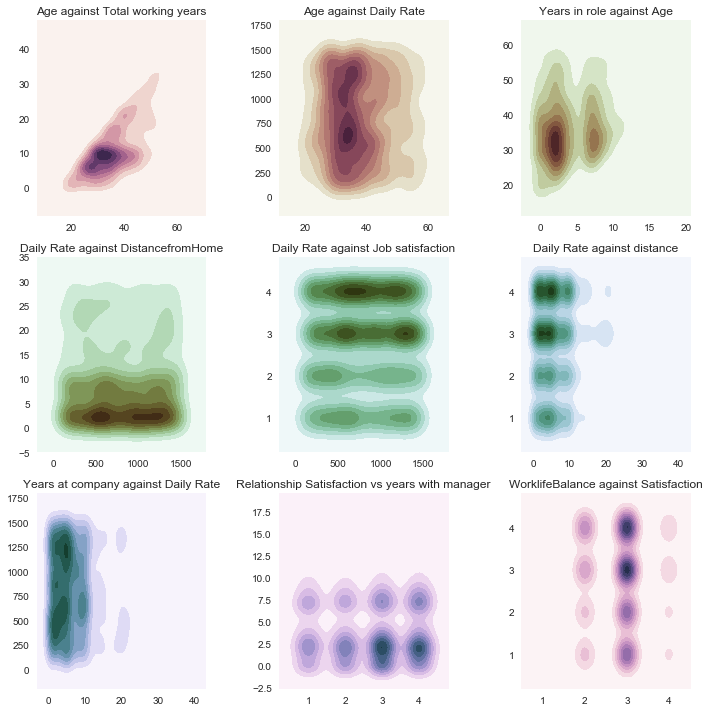

In [4]:
# Plotting the KDEplots
f, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=False, sharey=False)

# Defining our colormap scheme
s = np.linspace(0, 3, 10)
cmap = sns.cubehelix_palette(start=0.0, light=1, as_cmap=True)

# Generate and plot
x = attrition['Age'].values
y = attrition['TotalWorkingYears'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, cut=5, ax=axes[0,0])
axes[0,0].set( title = 'Age against Total working years')

cmap = sns.cubehelix_palette(start=0.333333333333, light=1, as_cmap=True)
# Generate and plot
x = attrition['Age'].values
y = attrition['DailyRate'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, ax=axes[0,1])
axes[0,1].set( title = 'Age against Daily Rate')

cmap = sns.cubehelix_palette(start=0.666666666667, light=1, as_cmap=True)
# Generate and plot
x = attrition['YearsInCurrentRole'].values
y = attrition['Age'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, ax=axes[0,2])
axes[0,2].set( title = 'Years in role against Age')

cmap = sns.cubehelix_palette(start=1.0, light=1, as_cmap=True)
# Generate and plot
x = attrition['DailyRate'].values
y = attrition['DistanceFromHome'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[1,0])
axes[1,0].set( title = 'Daily Rate against DistancefromHome')

cmap = sns.cubehelix_palette(start=1.333333333333, light=1, as_cmap=True)
# Generate and plot
x = attrition['DailyRate'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[1,1])
axes[1,1].set( title = 'Daily Rate against Job satisfaction')

cmap = sns.cubehelix_palette(start=1.666666666667, light=1, as_cmap=True)
# Generate and plot
x = attrition['YearsAtCompany'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[1,2])
axes[1,2].set( title = 'Daily Rate against distance')

cmap = sns.cubehelix_palette(start=2.0, light=1, as_cmap=True)
# Generate and plot
x = attrition['YearsAtCompany'].values
y = attrition['DailyRate'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[2,0])
axes[2,0].set( title = 'Years at company against Daily Rate')

cmap = sns.cubehelix_palette(start=2.333333333333, light=1, as_cmap=True)
# Generate and plot
x = attrition['RelationshipSatisfaction'].values
y = attrition['YearsWithCurrManager'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[2,1])
axes[2,1].set( title = 'Relationship Satisfaction vs years with manager')

cmap = sns.cubehelix_palette(start=2.666666666667, light=1, as_cmap=True)
# Generate and plot
x = attrition['WorkLifeBalance'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[2,2])
axes[2,2].set( title = 'WorklifeBalance against Satisfaction')

f.tight_layout()

In [5]:
# Define a dictionary for the target mapping
target_map = {'Yes':1, 'No':0}
# Use the pandas apply method to numerically encode our attrition target variable
attrition["Attrition_numerical"] = attrition["Attrition"].apply(lambda x: target_map[x])

### Correlation of Features

The next tool in a data explorer's arsenal is that of a correlation matrix. By plotting a correlation matrix, we have a very nice overview of how the features are related to one another. For a Pandas dataframe, we can conveniently use the call **.corr** which by default provides the Pearson Correlation values of the columns pairwise in that dataframe.

In this correlation plot, I will use the the Plotly library to produce a interactive Pearson correlation matrix via the Heatmap function as follows:

In [6]:
# creating a list of only numerical values
numerical = [u'Age', u'DailyRate', u'DistanceFromHome', u'Education', u'EmployeeNumber', u'EnvironmentSatisfaction',
       u'HourlyRate', u'JobInvolvement', u'JobLevel', u'JobSatisfaction',
       u'MonthlyIncome', u'MonthlyRate', u'NumCompaniesWorked',
       u'PercentSalaryHike', u'PerformanceRating', u'RelationshipSatisfaction',
       u'StockOptionLevel', u'TotalWorkingYears',
       u'TrainingTimesLastYear', u'WorkLifeBalance', u'YearsAtCompany',
       u'YearsInCurrentRole', u'YearsSinceLastPromotion',
       u'YearsWithCurrManager']
data = [
    go.Heatmap(
        z= attrition[numerical].astype(float).corr().values, # Generating the Pearson correlation
        x=attrition[numerical].columns.values,
        y=attrition[numerical].columns.values,
        colorscale='Viridis',
        reversescale = False,
        text = True ,
        opacity = 1.0
        
    )
]


layout = go.Layout(
    title='Pearson Correlation of numerical features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700,
    
)


fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

**Takeaway from the plots**

From the correlation plots, we can see that quite a lot of our columns seem to be poorly correlated with one another. Generally when making a predictive model, it would be preferable to train a model with features that are not too correlated with one another so that we do not need to deal with redundant features. In the case that we have quite a lot of correlated features one could perhaps apply a technique such as Principal Component Analysis (PCA) to reduce the feature space.

### Pairplot Visualisations

Now let us create some Seaborn pairplots and set it against the target variable which is our Attrition column to get a feel for how the various features are distributed vis-a-vis employee attrition

In [10]:
# Refining our list of numerical variables
numerical = [u'Age', u'DailyRate',  u'JobSatisfaction',
       u'MonthlyIncome', u'PerformanceRating',
        u'WorkLifeBalance', u'YearsAtCompany', u'Attrition_numerical']

#g = sns.pairplot(attrition[numerical], hue='Attrition_numerical', palette='seismic', diag_kind = 'kde',diag_kws=dict(shade=True))
#g.set(xticklabels=[])

# 2. Feature Engineering & Categorical Encoding

Having carried out a brief exploration into the dataset, let us now proceed onto the task of Feature engineering and numerically encoding the categorical values in our dataset. Feature engineering in a nutshell involves creating new features and relationships from the current features that we have. Feature engineering has been quite 

To start off, we shall segregate numerical columns from categorical columns via the use of the dtype method as follows:

In [7]:
# Drop the Attrition_numerical column from attrition dataset first - Don't want to include that
attrition = attrition.drop(['Attrition_numerical'], axis=1)

# Empty list to store columns with categorical data
categorical = []
for col, value in attrition.iteritems():
    if value.dtype == 'object':
        categorical.append(col)

# Store the numerical columns in a list numerical
numerical = attrition.columns.difference(categorical)

Having identified which of our features contain categorical data, we can set about numerically encoding the data. To do this, I shall use the **get_dummies** method from Pandas which creates encoded dummy variables from the categorical variables.

In [8]:
# Store the categorical data in a dataframe called attrition_cat
attrition_cat = attrition[categorical]
attrition_cat = attrition_cat.drop(['Attrition'], axis=1) # Dropping the target column

Applying the **get_dummies** method, we see that we have encoded our categorical values conveniently by just applying one line of Python code. 

In [9]:
attrition_cat = pd.get_dummies(attrition_cat)
attrition_cat.head(3)

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,1,0,1
1,0,1,0,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,1,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1


**Creating new features from Numerical data**

In [10]:
# Store the numerical features to a dataframe attrition_num
attrition_num = attrition[numerical]

Having encoded our categorical columns as well as engineering and created some new features from the numerical data, we can now proceed to merging both dataframes into a final set with which we will train and test our models on. 

In [11]:
# Concat the two dataframes together columnwise
attrition_final = pd.concat([attrition_num, attrition_cat], axis=1)

**Target variable**

One final step that that we have to remember is to generate our target variable. The target in this case is given by the column **Attrition** which contains categorical variables therefore requires numerical encoding. We numerically encode it by creating a dictionary with the mapping given as 1 : Yes and 0 : No

In [12]:
# Define a dictionary for the target mapping
target_map = {'Yes':1, 'No':0}
# Use the pandas apply method to numerically encode our attrition target variable
target = attrition["Attrition"].apply(lambda x: target_map[x])
target.head(3)

0    1
1    0
2    1
Name: Attrition, dtype: int64

However just by a quick inspection of the counts of the number of 'Yes' and 'No' in the target variable tells us that there is quite a large skew in target as shown

In [13]:
data = [go.Bar(
            x=attrition["Attrition"].value_counts().index.values,
            y= attrition["Attrition"].value_counts().values
    )]

py.iplot(data, filename='basic-bar')

Therefore we have to keep in mind that there is quite a big imbalance in our target variable. Many statistical techniques have been put forth to treat imbalances in data (oversampling or undersampling). In this notebook, I will use an oversampling technique known as SMOTE to treat this imbalance.

# 3. Implementing Machine Learning Models

Having performed some exploratory data analysis and simple feature engineering as well as having ensured that all categorical values are encoded, we are now ready to proceed onto building our models.

As alluded to in the introduction of this notebook, we will aim to evaluate and contrast the performances of a handful of different learning models. 

**Splitting Data into Train and Test sets**

But before we even start training a model, we will have to partition our dataset into a training set and a test set (unlike Kaggle competitions where the train and test data are already segregated for you). To split our data we will utilise sklearn's 

In [14]:
# Import the train_test_split method
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit

# Split data into train and test sets as well as for validation and testing
train, test, target_train, target_val = train_test_split(attrition_final, target, train_size= 0.75,random_state=0);
#train, test, target_train, target_val = StratifiedShuffleSplit(attrition_final, target, random_state=0);

**SMOTE to oversample due to the skewness in target**

Since we have already noted the severe imbalance in the values within the target variable, let us implement the SMOTE method in the dealing with this skewed value via the imblearn Python package.

In [15]:
oversampler=SMOTE(random_state=0)
smote_train, smote_target = oversampler.fit_sample(train,target_train)

## A. Random Forest Classifier 

The Random Forest method, first introduced by Breiman in 2001 can be grouped under the category of ensemble models. Why ensemble? The building block of a Random Forest is the ubiquitous Decision Tree. The decision tree as a standalone model is often considered a "weak learner" as its predictive performance is relatively poor. However a Random Forest gathers a group (or ensemble) of decision trees and uses their combined predictive capabilities to obtain relatively strong predictive performance - "strong learner". 

This principle of using a collection of "weak learners" to come together to create a "strong learner" underpins the basis of ensemble methods which one regularly comes across in Machine learning. For a really good read that drives home the basics of the Random Forest, refer to this [CitizenNet blog][1]


  [1]: http://blog.citizennet.com/blog/2012/11/10/random-forests-ensembles-and-performance-metrics

**Initialising Random Forest parameters**

We will utilise the Scikit-learn library to construct a Random Forest model. To do so, we have to first define our set of parameters that we will feed into our Random Forest classifier as follows

In [16]:
seed = 0   # We set our random seed to zero for reproducibility
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 800,
    'warm_start': True, 
    'max_features': 0.3,
    'max_depth': 9,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'random_state' : seed,
    'verbose': 0
}

Having defined our parameters, we can initialise a Random Forest object by using scikit-learn's **RandomForestClassifier** and unpacking the parameters by adding the double asterisks symbols as follows

In [17]:
rf = RandomForestClassifier(**rf_params)

The next step after prepping our Random Forest model would be to start building a forest of trees using our training set and fitting it to our attrition target variable. We do so by simply using the **fit** call as follows

In [18]:
rf.fit(smote_train, smote_target)
print("Fitting of Random Forest as finished")

Fitting of Random Forest as finished


Having fitted our forest of trees with our parameters to the training set against our target variable, we now have a learning model **rf** which we can make predictions out of. To use our Random Forest in predicting against our test data, we can use sklearn's **.predict** method as follows

In [19]:
rf_predictions = rf.predict(test)
print("Predictions finished")

Predictions finished


And a nice touch with sklearn (and the use of train_test_split method) is that you can conveniently set aside a part of the 

In [20]:
accuracy_score(target_val, rf_predictions)

0.87771739130434778

**Accuracy of the model**

As observed, our Random Forest returns an accuracy of 88% for its predictions. On first glance this might seem to be a very good performing model. However when we think about how skewed our target variable where the distribution of yes and no's are 84% and 26%, therefore our model is only predicting slightly better than random guessing.

### Feature Ranking via the Random Forest 

The Random Forest classifier in Sklearn also contains a very convenient and most useful attribute **feature_importances_** which tells us which features within our dataset has been given most importance through the Random Forest algorithm. Shown below is an Interactive Plotly diagram of the various feature importances.

In [21]:
# Scatter plot 
trace = go.Scatter(
    y = rf.feature_importances_,
    x = attrition_final.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = attrition_final.columns.values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

#### **Most RF important features** : Overtime, Marital Status

As observed in the plot of feature importances,  it seems that our Random Forest Classifier has decided to rank the features of OverTime highest, which is followed by marital status. 

I don't know about you, but working overtime to me does indeed affect my satisfaction derived from any job (and I have worked many an overtime). Maybe then it should come as no surprise that our classifier has caught on to this and thus ranked overtime the highest. 

### Visualising Tree Diagram with Graphviz

Let us now visualise how a single decision tree traverses the features in our data as the DecisionTreeClassifier object of sklearn comes with a very convenient **export_graphviz** method that exports the tree diagram into a .png format which you can view from the output of this kernel.

In [25]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth = 4)
decision_tree.fit(train, target_train)

# Predicting results for test dataset
y_pred = decision_tree.predict(test)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 4,
                              impurity = False,
                              feature_names = attrition_final.columns.values,
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
#check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png")

FileNotFoundError: [Errno 2] No such file or directory: 'tree1.png'

## B. Gradient Boosted Classifier

Gradient Boosting is also an ensemble technique much like the Random Forest where a combination of weak Tree learners are brought together to form a relatively stronger learner. The technique involves defining some sort of function (loss function) that you want minimised and an method/algorithm to minimise this. Therefore as the name suggests, the algorithm used to minimise the loss function is that of a gradient descent method which adds decision trees which "point" in the direction that reduces our loss function (downward gradient).

To set up a Gradient Boosting classifier is easy enough in Sklearn and it involves only a handful of lines of code. Again we first set up our classifier's parameters

**Initialising Gradient Boosting Parameters** 

In general there are a handful of key parameter when setting up tree-based or gradient boosted models. These are always going to be the number of estimators, the maximum depth with which you want your model to be trained to, and the minimum samples per leaf

In [26]:
# Gradient Boosting Parameters
gb_params ={
    'n_estimators': 500,
    'max_features': 0.9,
    'learning_rate' : 0.2,
    'max_depth': 11,
    'min_samples_leaf': 2,
    'subsample': 1,
    'max_features' : 'sqrt',
    'random_state' : seed,
    'verbose': 0
}

Having defined our parameters, we can now apply the usual fit and predict methods on our train and test sets respectively 

In [27]:
gb = GradientBoostingClassifier(**gb_params)
# Fit the model to our SMOTEd train and target
gb.fit(smote_train, smote_target)
# Get our predictions
gb_predictions = gb.predict(test)
print("Predictions have finished")

Predictions have finished


In [28]:
accuracy_score(target_val, gb_predictions)

0.87228260869565222

### Feature Ranking via the Gradient Boosting Model

Much like the Random Forest, we can invoke the feature_importances_ attribute of the gradient boosting model and dump it in an interactive Plotly chart

In [31]:
# Scatter plot 
trace = go.Scatter(
    y = gb.feature_importances_,
    x = attrition_final.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = gb.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = attrition_final.columns.values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Model Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter')

**Takeaway from the Plot**

**GBM most important features**  : Monthly Income, Overtime, Daily and Monthly Rate

Interestingly, the features that the Gradient Boosting model has placed its importance on differs quite greatly from that of the Random Forest. It has decided to rank features with a lot of economic significance highest such as the monthly income and the daily and monthly rate on top of placing importance on overtime. However what is puzzling is the inclusion of the Employee number as an important feature. 

This may be an edge case in the training or perhaps there is

### CONCLUSION

We have constructed a very simple pipeline of predicting employee attrition, from some basic Exploratory Data Analysis to feature engineering as well as implementing two learning models in the form of a Random Forest and a Gradient Boosting classifier. This whole notebook takes less than a minute to run and it even returns a 89% accuracy in its predictions.

That being said, there is quite a lot of room for improvement. For one, more features could be engineered from the data.  Furthermore one could squeeze performance out of this pipeline by perhaps using some form of blending or stacking of models. I myself am quite keen to implement a classifier voting where a handful of classifiers votes on the outcome of the predictions and we take the majority vote. 